#  Imports and data loading + train/test split + scaling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")   # 0/1 labels
print("Classes:", data.target_names)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Scale features (important for SVM)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

print("Train shape:", X_train_s.shape, "Test shape:", X_test_s.shape)

Classes: ['malignant' 'benign']
Train shape: (455, 30) Test shape: (114, 30)


# Train SVMs (Linear & RBF) and evaluate

In [2]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Linear SVM
svm_linear = SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE)
svm_linear.fit(X_train_s, y_train)
y_pred_linear = svm_linear.predict(X_test_s)
print("Linear SVM test accuracy:", accuracy_score(y_test, y_pred_linear))

# RBF SVM
svm_rbf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=RANDOM_STATE)
svm_rbf.fit(X_train_s, y_train)
y_pred_rbf = svm_rbf.predict(X_test_s)
print("RBF SVM test accuracy:", accuracy_score(y_test, y_pred_rbf))

print("\nRBF classification report:\n", classification_report(y_test, y_pred_rbf, target_names=data.target_names))

Linear SVM test accuracy: 0.9736842105263158
RBF SVM test accuracy: 0.9824561403508771

RBF classification report:
               precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



# Visualize decision boundary (2D via PCA)

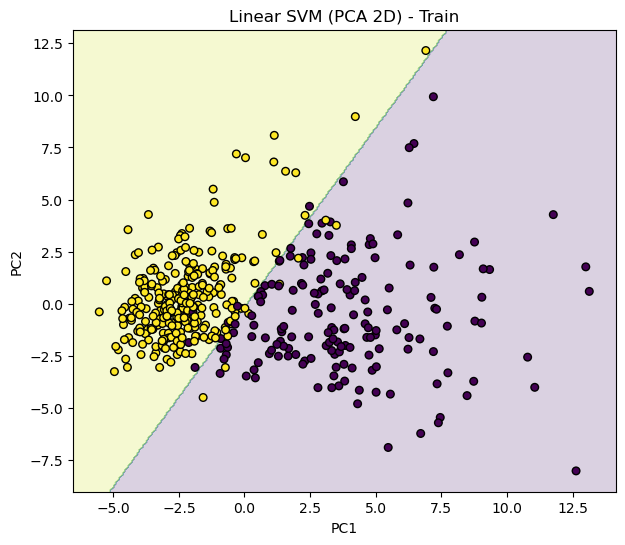

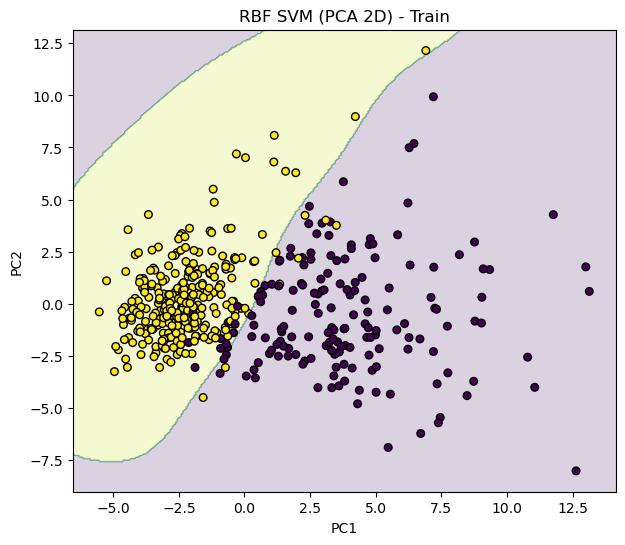

In [3]:
from sklearn.decomposition import PCA

# Fit PCA on scaled train data and transform both train & test
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_2d = pca.fit_transform(X_train_s)
X_test_2d  = pca.transform(X_test_s)

# Train SVMs on 2D data (only for visualization)
svm_linear_2d = SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE).fit(X_train_2d, y_train)
svm_rbf_2d    = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=RANDOM_STATE).fit(X_train_2d, y_train)

# Helper to plot decision boundary
def plot_decision_boundary(model, X2d, y, title):
    x_min, x_max = X2d[:,0].min() - 1.0, X2d[:,0].max() + 1.0
    y_min, y_max = X2d[:,1].min() - 1.0, X2d[:,1].max() + 1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X2d[:,0], X2d[:,1], c=y, edgecolor="k", s=30)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.show()

# Plot on training 2D data
plot_decision_boundary(svm_linear_2d, X_train_2d, y_train, "Linear SVM (PCA 2D) - Train")
plot_decision_boundary(svm_rbf_2d,    X_train_2d, y_train, "RBF SVM (PCA 2D) - Train")

# Tune hyperparameters (C, γ) with GridSearchCV

In [4]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid = [
    {"kernel": ["linear"], "C": [0.01, 0.1, 1, 10]},
    {"kernel": ["rbf"], "C": [0.1, 1, 10], "gamma": [0.001, 0.01, 0.1, "scale"]},
]

svc = SVC(random_state=RANDOM_STATE)
grid = GridSearchCV(svc, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_s, y_train)

print("Best params:", grid.best_params_)
print("Best CV score (train):", grid.best_score_)

best_svm = grid.best_estimator_
print("Test accuracy (best model):", best_svm.score(X_test_s, y_test))

Best params: {'C': 0.1, 'kernel': 'linear'}
Best CV score (train): 0.9758241758241759
Test accuracy (best model): 0.9824561403508771


# Cross-validation to evaluate performance

In [5]:
from sklearn.model_selection import cross_val_score

# Cross-val on entire training set using best estimator
cv_scores = cross_val_score(best_svm, X_train_s, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
print("CV accuracy mean ± std:", cv_scores.mean(), "+/-", cv_scores.std())

# Compare baseline CV scores for linear and rbf (optional quick check)
linear_cv = cross_val_score(SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE), X_train_s, y_train, cv=cv, n_jobs=-1)
rbf_cv = cross_val_score(SVC(kernel="rbf", C=1.0, gamma="scale", random_state=RANDOM_STATE), X_train_s, y_train, cv=cv, n_jobs=-1)
print("Linear CV mean:", linear_cv.mean(), "RBF CV mean:", rbf_cv.mean())

CV accuracy mean ± std: 0.9758241758241759 +/- 0.010766987880365607
Linear CV mean: 0.9648351648351647 RBF CV mean: 0.9670329670329672
